# dfencoder Demo: Census Dataset
This is a demonstration of the dfencoder library. We will use the [adult census dataset](https://archive.ics.uci.edu/ml/datasets/adult) for this demo.

In [1]:
#these are our libraries
from dfencoder import AutoEncoder
import pandas as pd

#and, for pretty visualiations...
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%config InlineBackend.figure_format = 'retina'

# About the Data
This dataset contains information about 32,561 adults (in the training set), with a number of features.<br><br>
Traditionally, the target variable is "salary," a binary feature with "<50k" and ">=50k" as its two values. For this now, we'll treat this column as we do all the others.

In [2]:
#load and look at the data
df = pd.read_csv('adult.csv')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


# Validation on Hold-Out Set
Even in unsupervised learning, it's a good idea to do a train/validation split during training. This will help you fine-tune your model and avoid overfitting. Let's hold out 20% of the examples.

In [3]:
train = df.sample(frac=.8, random_state=42)
test = df.loc[~df.index.isin(train.index)]

X_train = train
X_val = test

# Building A Model
Applying DAE, you have to make a lot of choices. How many hidden layers does your model have? What activations will you use? Learning rate? Optimizer? What noise level do you want to apply to the inputs during training?<br>
What about feature scaling? Do you want to use uniform scaling or standard scaling? What about [GaussRank scaling](http://fastml.com/preparing-continuous-features-for-neural-networks-with-rankgauss/), the technique used in a kaggle-winning competition?<br>
dfencoder aims to free you from the burden of data munging so you can focus on optimizing these parameters. Here's an example of how to feed these hyperparameters to your model.

In [4]:
model = AutoEncoder(
    encoder_layers = [512, 512, 512], #model architecture
    decoder_layers = [], #decoder optional - you can create bottlenecks if you like
    activation='relu',
    swap_p=0.15, #noise parameter
    lr = 0.01,
    lr_decay=.99,
    logger='ipynb', #special logging for jupyter notebooks
    verbose=False,
    optimizer='sgd',
    scaler='gauss_rank', #gauss rank scaling forces your numeric features into standard normal distributions
    min_cats=3 #Define cutoff for minority categories
)

# Fitting the Model
Notice your model doesn't know about the data yet. The model itself won't be built until you call .fit(); on the .fit() call, the model will use the column-wise data types of the input dataframe to determine how to treat each column:
 - Numeric (float or int) columns will be scaled and treated as continuous variables.
     - MSE loss is used for loss on these columns during training.
 - Categorical (str or 'object') columns will be treated as categorical, with minority classes (frequency < min_cats argument in constructor) being lumped into a special 'N/A' category.
     - Categorical Cross Entropy is used as a loss during training.
     - These features are embedded into category vectors before being fed into the model.
     - [Category embeddings](https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0) enable efficient learning of relationships between unique categories.
 - Binary (bool or 'object' where n_unique < 3) columns will be treated as binary features.
     - Binary Cross Entropy is used as loss.
     
## Advice on Data Preparation.

     
The idea is to save you time on feature engineering. If you want, you can just throw a dataframe into the .fit() method and something will happen.<br><br>However, you need to understand the way this library is dealing with your data and how it decides what to do. Make sure to clean up your data - pay attention to dtypes - before calling .fit(). This is how you can specify how the model treats each column!

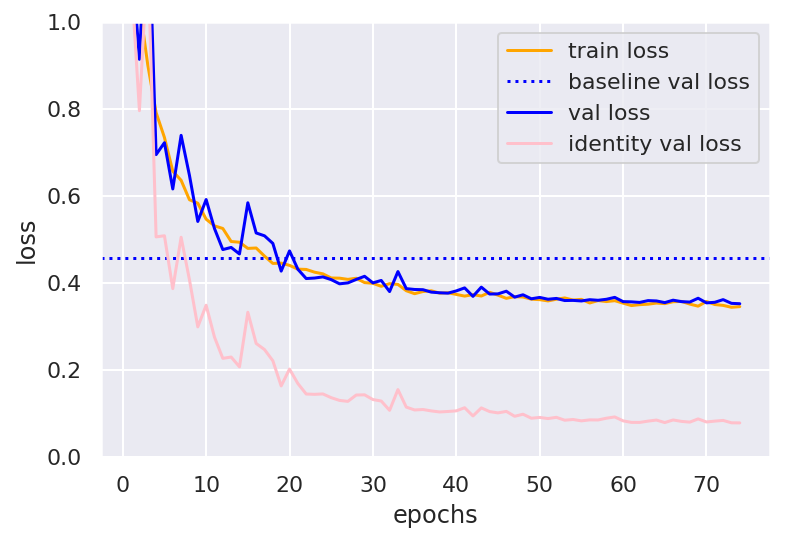

 83%|████████▎ | 85/102 [00:07<00:01, 12.76it/s]

KeyboardInterrupt: 

In [5]:
model.fit(X_train, epochs=1000, val=X_val)

# Model Evaluation
How can we tell if the model is performing well? In supervised learning, the answer is straightforward. In self-supervised learning, it may not be so clear at first glance. There are a few terms to consider:
<br>
## Loss
When we talk about loss here, we're talking about the "reconstruction loss." That is, how well does the model predict the *correct* version of the example it's seeing?
## Baseline Validation Loss
If we apply swap noise to our validation set and compute the loss given a strong prediction for the identity function, we can get an idea for what loss to expect from the model when it learns the trivial identity function. You'll see this value printed to your console (or plotted in your notebook if you use the ipynb logger, as in this notebook). Ideally, our model will learn to perform significantly better than this baseline.
## Validation Loss
Keeping the swap noise constant (same input as used in computing baseline), we can see how our model does at the end of each epoch on reconstructing the original, unaltered validation set. This is our standard validation loss. Note: we don't re-apply swap noise on each epoch. We want to keep the validation task constant so each evaluation step is compared "apples-to-apples."
## Identity Loss
The "identity loss" is computed by measuring the reconstruction loss when inputs to the model are unaltered. Although learning the identity function is trivial, a low identity loss in combination with a low validation loss indicates that the model is good at identifying unaltered examples and returning an unchanged output.

# Now What?
The question now is, what can we do with our model? There are a number of applications. Let's look at a few of them.
## "Deep Stack" Features
As in the kaggle-winning solution to the Porto Seguro Safe Driver Prediction competition, we can simply use all the activations concatenated together to extract a bunch of latent features from each example:

In [ ]:
z = model.get_deep_stack_features(X_val)
print(z.shape)
print(z[0, :])

In this case, we see that each row now has 1,536 new features associated with it. What can we do with them?
We could start by building a model predict the target feature, "salary".
### BUT WAIT!
Didn't we use salary to train the autoencoder? Won't we be cheating?<br><br>
Well, maybe. In a moment we'll see why that's not exactly important. Let's try to build a model anyway.

In [ ]:
X_train.salary.unique()

In [ ]:
f1_score()

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import torch
import tqdm

class ClassifierModel(torch.nn.Module):
    """A simple classifier neural network."""
  
    def __init__(self, *args, **kwargs):
        super(ClassifierModel, self).__init__(*args, **kwargs)
        self.input_dropout = torch.nn.Dropout(.1)
        self.input_layer = torch.nn.Linear(1536, 512)
        self.dropout = torch.nn.Dropout(.5)
        self.dense = torch.nn.Linear(512, 512)
        self.output = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)

        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
    
classifier = ClassifierModel()

optim = torch.optim.Adam(
    classifier.parameters(),
    weight_decay=.01
)

decay = torch.optim.lr_scheduler.ExponentialLR(optim, .99)

loss = torch.nn.modules.loss.BCELoss()

def do_step(classifier, optim, z, target, loss):
    pred = classifier(z)
    target = torch.tensor(target).float().reshape(-1, 1)
    loss_ = loss(pred, target)
    amnt = loss_.item()
    loss_.backward()
    optim.step()
    optim.zero_grad()
    return amnt

def do_evaluation(classifier, z, target, loss):
    with torch.no_grad():
        pred = classifier(z)
        probs = pred.numpy().reshape(-1)
        predictions = np.where(probs > .5, 1, 0)

        accuracy = np.where(target==predictions, 1, 0).sum()/len(predictions)
        f1 = f1_score(target, predictions)

        target_ = torch.tensor(target).float().reshape(-1, 1)
        loss_ = loss(pred, target_)
        return loss_.item(), accuracy, f1

  
batch_size = 256
n_updates = (len(X_train)//batch_size) + 1

n_epochs = 1000

#To extract features, we'll set the target column on the input
#equal to the majority class: <50k

X_train2 = X_train.copy()
X_train2['salary'] = ['<50k' for _ in X_train2['salary']]
z_train = model.get_deep_stack_features(X_train2)

Y_train = np.where(X_train['salary'].values == '<50k', 0, 1)

X_test2 = X_val.copy()
X_test2['salary'] = ['<50k' for _ in X_test2['salary']]
z_test = model.get_deep_stack_features(X_test2)
Y_test = np.where(X_val['salary'].values == '<50k', 0, 1)

for j in range(n_epochs):
    for i in tqdm.trange(n_updates):
        step = i
        start = int((step) * batch_size)
        stop = int((step+1) * batch_size)
        in_ = z_train[start:stop]
        target = Y_train[start:stop]
        do_step(classifier, optim, in_, target, loss)
    decay.step()
    bce_loss, accuracy, f1 = do_evaluation(classifier, z_test, Y_test, loss)
    print('validation loss: ', round(bce_loss, 4))
    print('validation accuracy: ', round(accuracy, 3))
    print('validation f1 score: ', round(f1, 3))

We got something. It might not be the best model but whatever. It's there

In [ ]:
model2 = AutoEncoder(
    encoder_layers = [256, 256, 256, 128],
    decoder_layers = [],
    activation='relu',
    swap_p=0.1,
    lr = 0.01,
    lr_decay=.99,
    logger='ipynb',
    verbose=False,
    scaler='gauss_rank',
    optimizer='adam',
    min_cats=3
)

model2.fit(X_train, epochs=100, val=X_val)

In [ ]:
n_rows = 42594
n_megabatches = 10
batch_size = 256
res = n_rows/n_megabatches
batches_per_megabatch = (res // batch_size) + 1
megabatch_size = batches_per_megabatch * batch_size
final_batch_size = n_rows - (n_megabatches - 1) * megabatch_size

In [ ]:
from scipy.spatial.distance import cosine

def compare_category(feature, cat):
    cats = feature['cats']
    scores = []
    this_cat = cats.index(cat)
    emb = feature['embedding']
    
    ft_embedding = emb.weight.data.numpy()[this_cat, :]
    
    for i, cat_ in enumerate(cats):
        vec = emb.weight.data.numpy()[i, :]
        similarity = cosine(ft_embedding, vec)
        scores.append(similarity)
        
    scrnm = f'distance from {cat}'
    result = pd.DataFrame(columns=['category', scrnm])
    result['category'] = cats
    result[scrnm] = scores
    
    print(result.sort_values(scrnm))
    
    

compare_category(model2.categorical_fts['native-country'], ' United-States')

In [ ]:
df.head()

In [ ]:
plt.hist(df['age'])
plt.show()

from sklearn.preprocessing import QuantileTransformer

tf = QuantileTransformer(output_distribution='normal')
x_ = tf.fit_transform(df['age'].values.reshape(-1, 1))
plt.hist(x_, bins=25)
plt.show()

In [ ]:
x_.shape

In [ ]:
Y.value_counts()

In [ ]:
import numpy as np

#X_val['salary'] = np.random.choice(['>=50k', '<50k'], size=Y.shape)
X_val['salary'] = ['>=50k' for _ in Y]
df_hat = model.df_predict(X_val)
Y_hat = df_hat['salary']

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y, Y_hat))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

Y = train.salary

lr.fit(z.detach().numpy(), Y)

In [ ]:
Y_hat = lr.predict(model.get_vector(X_val).detach().numpy())

In [ ]:
(Y_hat == test.salary).sum()/len(test)

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(test.salary, Y_hat))

In [ ]:
import torch

In [ ]:
a = torch.tensor([0, 1, 0])
(a==0).float() * .1
(a==1).float() * -.1

In [ ]:
from scipy.special import softmax

In [ ]:
import numpy as np

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

scores = [3, 0.0, 0.0]
print(softmax(scores))

In [ ]:
import torch

test_inp = torch.tensor([0, 3, 5, 6, 8])


def ohe(input_vector, dim):
    batch_size = len(input_vector)
    nb_digits = dim

    y = input_vector.reshape(-1, 1)
    y_onehot = torch.FloatTensor(batch_size, nb_digits)

    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    
    return y_onehot

y_onehot = ohe(test_inp, dim=11)
print(y_onehot*1)
    


In [ ]:
from collections import OrderedDict

In [ ]:
b = OrderedDict()
b['a'] = 1
b['b'] = 2
b['3'] = 3

In [ ]:
c = pd.Categorical(values = ['a', 'man', 'has', 'hands'], categories=['a', 'has', 'man'])
c._set_codes([0, 0, 0, 0])

In [ ]:
import torch
isinstance(torch.optim.Adam([None]), torch.optim.Optimizer)

In [ ]:
torch.optim.Optimizer

In [ ]:
df.head()

In [ ]:
['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary']

In [ ]:
import pandas as pd
import numpy as np
from dfencoder import EncoderDataFrame

df = pd.DataFrame()

df['a'] = [0, 2, 4, 6, 1, 5, 2, 6, 7]
df['b'] = [2.2, 3.1, 0.1, -.2, 0.4, 6.7, 2.2, 3.3, 1.1]
df['cat'] = ['dog', 'cat', 'fish', 'bird', 'elephant', 'giraffe', 'lion', 'tiger', 'bear']

indices = [
    [1, 2], [0, 2]
]

n_rows = 2
tot_rows = len(df)
n_cols = len(df.columns)

def gen_indices():
    column = np.repeat(np.arange(n_cols).reshape(1, -1), repeats=n_rows, axis=0)
    row = np.random.randint(0, tot_rows, size=(n_rows, n_cols))
    return row, column

row, column = gen_indices()
to_place = df.values[row, column]

row, column = gen_indices()
new_mat = df.values
new_mat[row, column] = to_place

dtypes = {col:typ for col, typ in zip(df.columns, df.dtypes)}
new_df = pd.DataFrame(columns=dtypes, data=new_mat)
new_df = new_df.astype(dtypes)
new_df.dtypes

In [ ]:
df = EncoderDataFrame(df)
df

In [ ]:
df = EncoderDataFrame()
df['make'] = ['honda', 'ferrari']
df['model'] = ['civic', 'portofino']
df['color'] = ['silver', 'red']
df['year'] = [2004, 2020]
df

In [ ]:
x = np.empty((10,), dtype=[('x', np.uint8), ('y', np.float64)])
df = pd.DataFrame(x)

df['x'].dtype

In [ ]:
row = np.array([
    [5, 2, 3],
    [1, 2, 4]
])

column = np.array([
    [0, 1, 2],
    [0, 1, 2]
])

cop = df.values[row, column]
type(cop[0, 1])

In [ ]:
from dfencoder import EncoderDataFrame

ef = EncoderDataFrame(df)

In [ ]:
ef.swap()